# DPM-Solver vs DDIM Comparison

In this section, we show that DPM-Solver generates images with similar quality to DDMi Scheduler faster (usually with 10-20 NFE, DPM-Solver can have good quality results)

In [2]:
!pip install clean-fid

In [3]:
import torch
from diffusers import DiffusionPipeline, DDPMPipeline, DDIMScheduler, UNet2DModel, DPMSolverMultistepScheduler, DDPMScheduler, DDIMPipeline
from torchvision import datasets, transforms
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from diffusers import UNet2DModel
import PIL.Image
import tqdm
from cleanfid import fid
import os

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008663595..1.0075605].


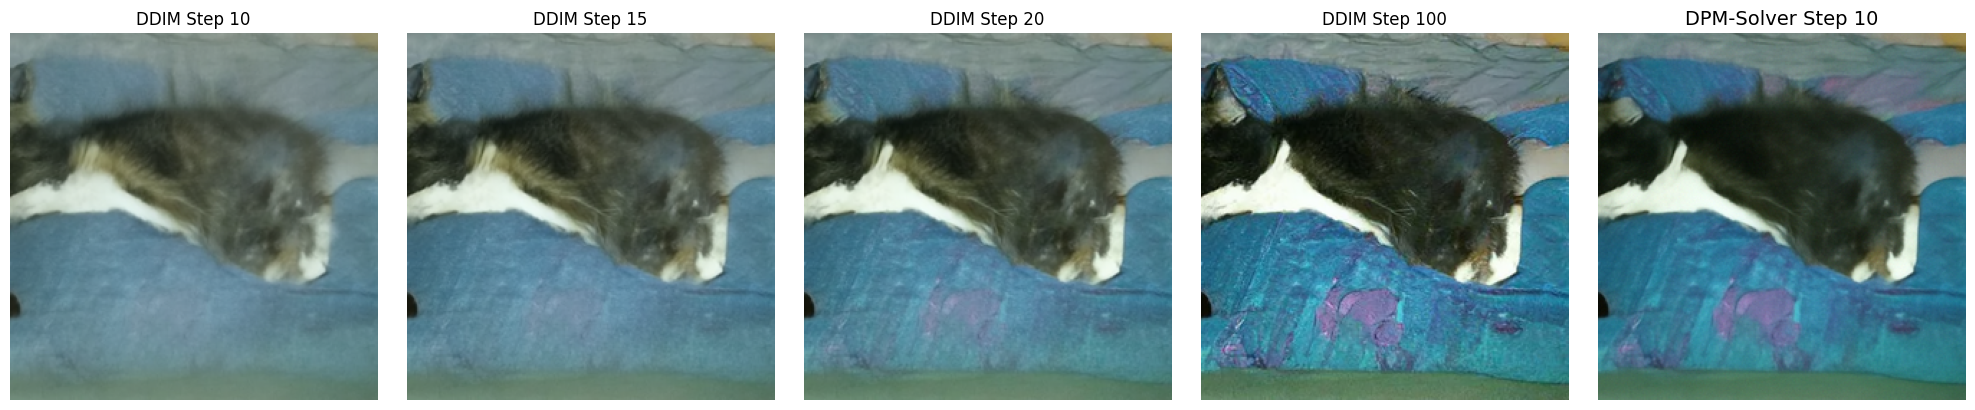

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/infres/cchavez-23/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/infres/cchavez-23/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
100%|██████████| 100/100 [02:01<00:00,  1.21s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057311952..1.0558798].


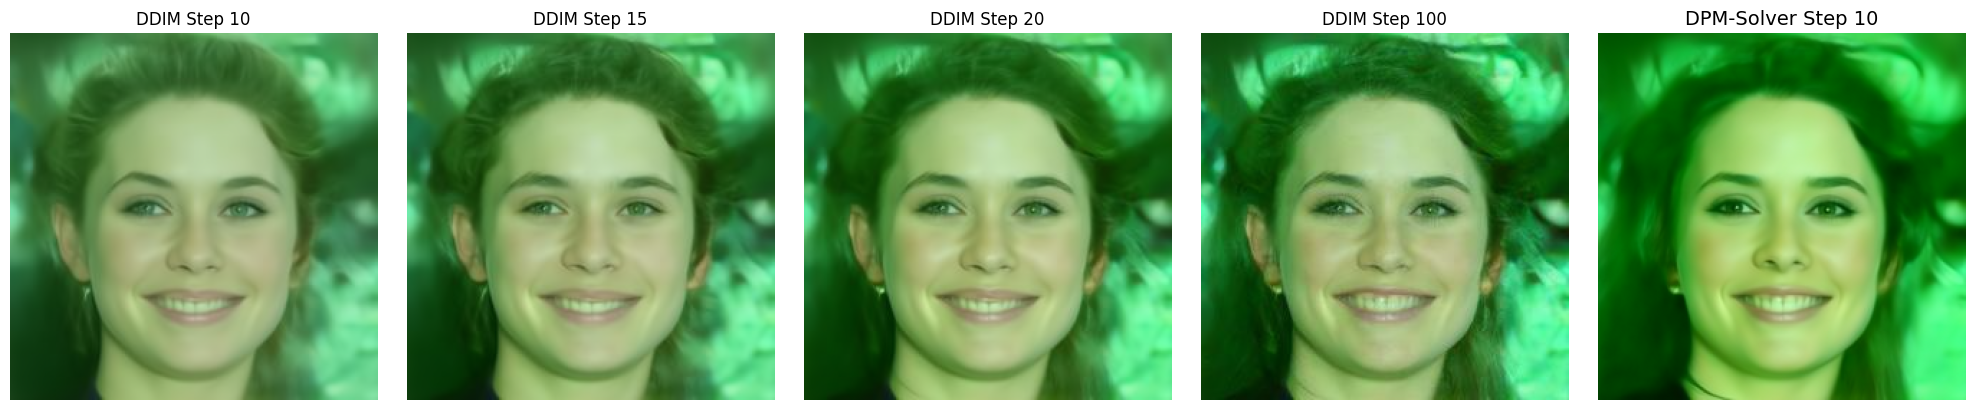

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:06<00:00, 14.36it/s]


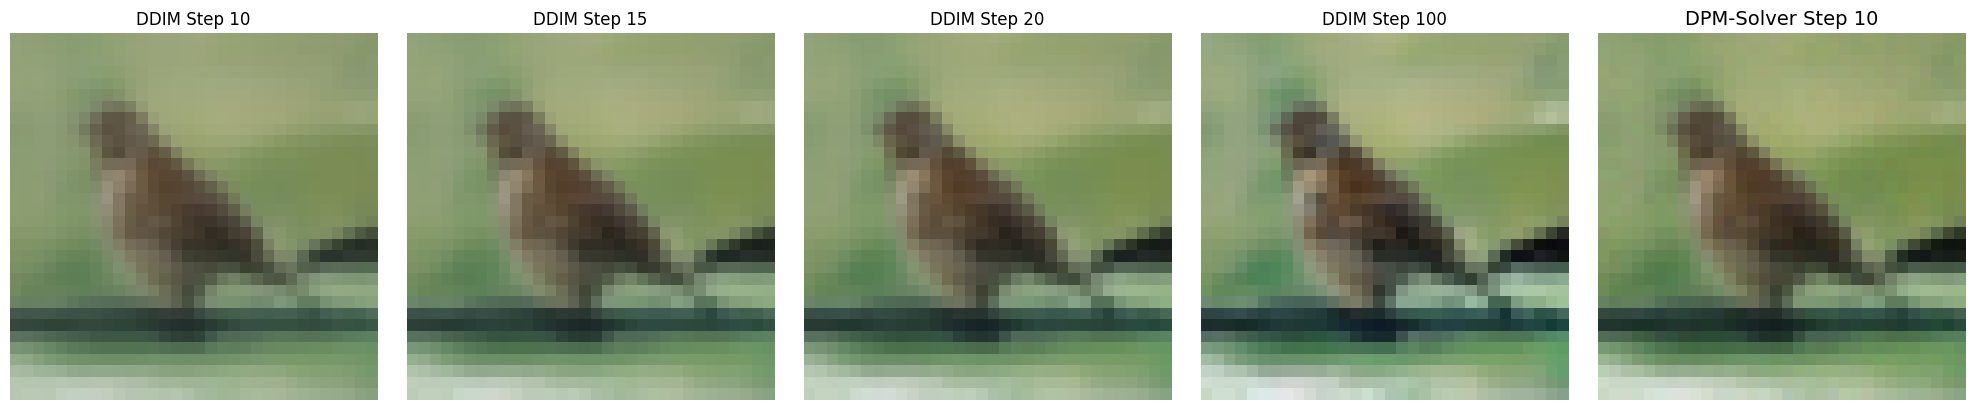

In [ ]:
def generate_images_with_scheduler(model, scheduler, num_steps, initial_noise, steps_to_plot):
    scheduler.set_timesteps(num_inference_steps=num_steps)
    sample = initial_noise.clone()
    images = []

    for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
        with torch.no_grad():
            residual = model(sample, t).sample
        sample = scheduler.step(residual, t, sample).prev_sample

        if (i + 1) in steps_to_plot:  # Store images for specific iterations
            images.append((i + 1, sample.cpu().permute(0, 2, 3, 1).squeeze().numpy()))

    return images

# Set seed for reproducibility
torch.manual_seed(2)

# List of dataset repositories
datasets = ["google/ddpm-cat-256", "google/ddpm-celebahq-256", "google/ddpm-cifar10-32"]

for repo_id in datasets:
    # Load pre-trained model
    pipe = DDPMPipeline.from_pretrained(repo_id)

    # Initialize schedulers
    ddim_scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    dpm_solver_scheduler_3 = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, algorithm_type="dpmsolver", final_sigmas_type="sigma_min", solver_order=3)

    # Number of steps for evaluation
    num_steps_10 = 10
    num_steps_15 = 15
    num_steps_20 = 20
    num_steps_100 = 100

    model = pipe.unet
    # Generate initial noise
    initial_noise = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size)

    # Generate images for each scheduler
    dpm_solver_images_3 = generate_images_with_scheduler(model, dpm_solver_scheduler_3, num_steps=num_steps_10, initial_noise=initial_noise, steps_to_plot=[num_steps_10])
    ddim_images_10 = generate_images_with_scheduler(model, ddim_scheduler, num_steps=num_steps_10, initial_noise=initial_noise, steps_to_plot=[num_steps_10])
    ddim_images_15 = generate_images_with_scheduler(model, ddim_scheduler, num_steps=num_steps_15, initial_noise=initial_noise, steps_to_plot=[num_steps_15])
    ddim_images_20 = generate_images_with_scheduler(model, ddim_scheduler, num_steps=num_steps_20, initial_noise=initial_noise, steps_to_plot=[num_steps_20])
    ddim_images_100 = generate_images_with_scheduler(model, ddim_scheduler, num_steps=num_steps_100, initial_noise=initial_noise, steps_to_plot=[num_steps_100])

    # Extract the images for plotting
    dpm_solver_img_10 = [img for idx, img in dpm_solver_images_3 if idx == num_steps_10][0]
    ddim_img_10 = [img for idx, img in ddim_images_10 if idx == num_steps_10][0]
    ddim_img_15 = [img for idx, img in ddim_images_15 if idx == num_steps_15][0]
    ddim_img_20 = [img for idx, img in ddim_images_20 if idx == num_steps_20][0]
    ddim_img_100 = [img for idx, img in ddim_images_100 if idx == num_steps_100][0]

    # Plotting the results
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))

    ax[0].imshow((ddim_img_10 + 1.0) * 127.5 / 255)
    ax[0].axis('off')
    ax[0].set_title(f"DDIM Step 10", fontsize=12)

    ax[1].imshow((ddim_img_15 + 1.0) * 127.5 / 255)
    ax[1].axis('off')
    ax[1].set_title(f"DDIM Step 15", fontsize=12)

    ax[2].imshow((ddim_img_20 + 1.0) * 127.5 / 255)
    ax[2].axis('off')
    ax[2].set_title(f"DDIM Step 20", fontsize=12)

    ax[3].imshow((ddim_img_100 + 1.0) * 127.5 / 255)
    ax[3].axis('off')
    ax[3].set_title(f"DDIM Step 100", fontsize=12)

    ax[4].imshow((dpm_solver_img_10 + 1.0) * 127.5 / 255)
    ax[4].axis('off')
    ax[4].set_title(f"DPM-Solver Step 10", fontsize=14)  # Emphasized title

    plt.tight_layout()
    # Save the plot as an image file with a unique name per dataset
    plot_filename = f'comparison_plot_{repo_id.split("/")[-1]}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()

# FID Comparison

In this section we want to show the comparison of the FID values for the DDPM, and the schedulers DDIM and DPPM-Solver

At the same time, we want to show, that the bigger the number of samples generated by each model to evaluate the FID value, the smaller the FID value (the closer to real distribution it gets)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_1_DDPM_cifar10_images_10


FID NFE_1_DDPM_cifar10_images_10 : 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_2_DDPM_cifar10_images_10


FID NFE_2_DDPM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_3_DDPM_cifar10_images_10


FID NFE_3_DDPM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_4_DDPM_cifar10_images_10


FID NFE_4_DDPM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_5_DDPM_cifar10_images_10


FID NFE_5_DDPM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_7_DDPM_cifar10_images_10


FID NFE_7_DDPM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_10_DDPM_cifar10_images_10


FID NFE_10_DDPM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_1_DPM_solver_cifar10_images_10


FID NFE_1_DPM_solver_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_2_DPM_solver_cifar10_images_10


FID NFE_2_DPM_solver_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_3_DPM_solver_cifar10_images_10


FID NFE_3_DPM_solver_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_4_DPM_solver_cifar10_images_10


FID NFE_4_DPM_solver_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_5_DPM_solver_cifar10_images_10


FID NFE_5_DPM_solver_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_7_DPM_solver_cifar10_images_10


FID NFE_7_DPM_solver_cifar10_images_10 : 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_10_DPM_solver_cifar10_images_10


FID NFE_10_DPM_solver_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_1_DDIM_cifar10_images_10


FID NFE_1_DDIM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_2_DDIM_cifar10_images_10


FID NFE_2_DDIM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_3_DDIM_cifar10_images_10


FID NFE_3_DDIM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_4_DDIM_cifar10_images_10


FID NFE_4_DDIM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_5_DDIM_cifar10_images_10


FID NFE_5_DDIM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_7_DDIM_cifar10_images_10


FID NFE_7_DDIM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


compute FID of a folder with cifar10 statistics
Found 10 images in the folder generated_images_comparison/NFE_10_DDIM_cifar10_images_10


FID NFE_10_DDIM_cifar10_images_10 : 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Plot saved as fid_comparison_10_images_per_folder.png


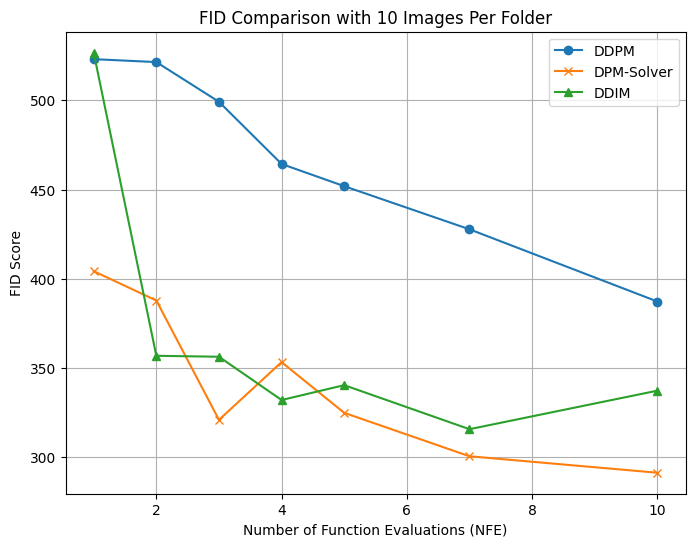

compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_1_DDPM_cifar10_images_100


FID NFE_1_DDPM_cifar10_images_100 : 100%|██████████| 4/4 [00:12<00:00,  3.09s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_2_DDPM_cifar10_images_100


FID NFE_2_DDPM_cifar10_images_100 : 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_3_DDPM_cifar10_images_100


FID NFE_3_DDPM_cifar10_images_100 : 100%|██████████| 4/4 [00:14<00:00,  3.52s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_4_DDPM_cifar10_images_100


FID NFE_4_DDPM_cifar10_images_100 : 100%|██████████| 4/4 [00:15<00:00,  3.80s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_5_DDPM_cifar10_images_100


FID NFE_5_DDPM_cifar10_images_100 : 100%|██████████| 4/4 [00:16<00:00,  4.08s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_7_DDPM_cifar10_images_100


FID NFE_7_DDPM_cifar10_images_100 : 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_10_DDPM_cifar10_images_100


FID NFE_10_DDPM_cifar10_images_100 : 100%|██████████| 4/4 [00:14<00:00,  3.56s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_1_DPM_solver_cifar10_images_100


FID NFE_1_DPM_solver_cifar10_images_100 : 100%|██████████| 4/4 [00:12<00:00,  3.21s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_2_DPM_solver_cifar10_images_100


FID NFE_2_DPM_solver_cifar10_images_100 : 100%|██████████| 4/4 [00:13<00:00,  3.43s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_3_DPM_solver_cifar10_images_100


FID NFE_3_DPM_solver_cifar10_images_100 : 100%|██████████| 4/4 [00:14<00:00,  3.72s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_4_DPM_solver_cifar10_images_100


FID NFE_4_DPM_solver_cifar10_images_100 : 100%|██████████| 4/4 [00:15<00:00,  3.97s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_5_DPM_solver_cifar10_images_100


FID NFE_5_DPM_solver_cifar10_images_100 : 100%|██████████| 4/4 [00:16<00:00,  4.16s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_7_DPM_solver_cifar10_images_100
compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_10_DPM_solver_cifar10_images_100


FID NFE_10_DPM_solver_cifar10_images_100 : 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_1_DDIM_cifar10_images_100


FID NFE_1_DDIM_cifar10_images_100 : 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_2_DDIM_cifar10_images_100


FID NFE_2_DDIM_cifar10_images_100 : 100%|██████████| 4/4 [00:13<00:00,  3.32s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_3_DDIM_cifar10_images_100


FID NFE_3_DDIM_cifar10_images_100 : 100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_4_DDIM_cifar10_images_100


FID NFE_4_DDIM_cifar10_images_100 : 100%|██████████| 4/4 [00:15<00:00,  3.94s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_5_DDIM_cifar10_images_100


FID NFE_5_DDIM_cifar10_images_100 : 100%|██████████| 4/4 [00:16<00:00,  4.20s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_7_DDIM_cifar10_images_100


FID NFE_7_DDIM_cifar10_images_100 : 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


compute FID of a folder with cifar10 statistics
Found 100 images in the folder generated_images_comparison/NFE_10_DDIM_cifar10_images_100


FID NFE_10_DDIM_cifar10_images_100 : 100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


Plot saved as fid_comparison_100_images_per_folder.png


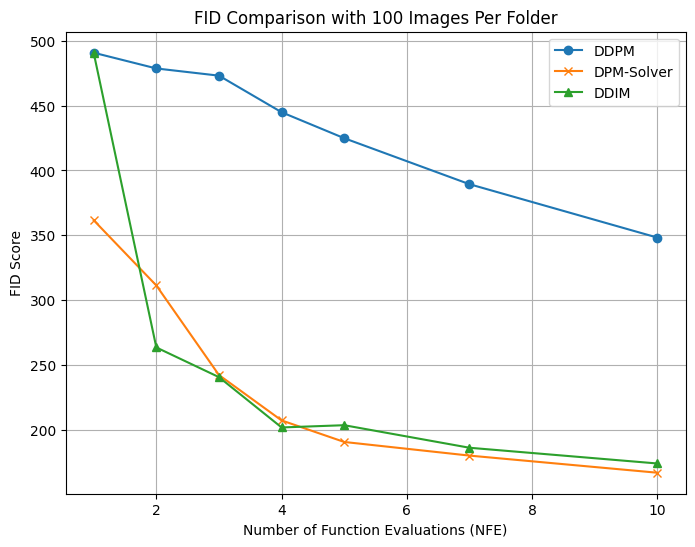

In [7]:
base_dir = "generated_images_comparison"

# Function to generate and save images, and compute FID scores
def generate_and_save_images(pipe, model_name, steps, dataset_name, res, images_per_folder):
    scores = []
    for step in steps:
        step_dir = os.path.join(base_dir, f"NFE_{step}_{model_name}_{dataset_name}_images_{images_per_folder}")
        os.makedirs(step_dir, exist_ok=True)

        # Generate and save images_per_folder images for each step
        for i in range(images_per_folder):
            generated_image = pipe(num_inference_steps=step).images[0]
            image_path = os.path.join(step_dir, f"image_{i}_step_{step}.png")
            generated_image.save(image_path)

        # Compute FID score without progress output
        fid_score = fid.compute_fid(step_dir, dataset_name=dataset_name, dataset_res=res, dataset_split="train")
        scores.append(fid_score)
    return scores

# Load the pre-trained models
ddpm_pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
ddpm_pipe.set_progress_bar_config(disable=True)
ddpm_pipe = ddpm_pipe.to("cuda")

dpm_solver_pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
dpm_solver_pipe.scheduler = DPMSolverMultistepScheduler.from_config(dpm_solver_pipe.scheduler.config, solver_order=3, algorithm_type="dpmsolver", final_sigmas_type="sigma_min")
dpm_solver_pipe.set_progress_bar_config(disable=True)
dpm_solver_pipe = dpm_solver_pipe.to("cuda")

ddimp_solver_pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
ddimp_solver_pipe.scheduler = DDIMScheduler.from_config(ddimp_solver_pipe.scheduler.config)
ddimp_solver_pipe.set_progress_bar_config(disable=True)
ddimp_solver_pipe = ddimp_solver_pipe.to("cuda")

# Define the steps to be used for both models
steps_to_evaluate = [1, 2, 3, 4, 5, 7, 10]

# Function to plot and save FID scores
def plot_fid_comparison(steps, scores_ddpm, scores_dpm_solver, scores_ddimp_solver, images_per_folder):
    plt.figure(figsize=(8, 6))
    plt.plot(steps, scores_ddpm, marker='o', label='DDPM')
    plt.plot(steps, scores_dpm_solver, marker='x', label='DPM-Solver')
    plt.plot(steps, scores_ddimp_solver, marker='^', label='DDIM')
    plt.xlabel("Number of Function Evaluations (NFE)")
    plt.ylabel("FID Score")
    plt.title(f"FID Comparison with {images_per_folder} Images Per Folder")
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_filename = f"fid_comparison_{images_per_folder}_images_per_folder.png"
    plt.savefig(plot_filename)
    print(f"Plot saved as {plot_filename}")

    plt.show()

# Generate and save images for different `images_per_folder` values
for images_per_folder in [10, 100]:
    fid_scores_ddpm = generate_and_save_images(ddpm_pipe, "DDPM", steps_to_evaluate, "cifar10", 32, images_per_folder)
    fid_scores_dpm_solver = generate_and_save_images(dpm_solver_pipe, "DPM_solver", steps_to_evaluate, "cifar10", 32, images_per_folder)
    fid_scores_ddimp_solver = generate_and_save_images(ddimp_solver_pipe, "DDIM", steps_to_evaluate, "cifar10", 32, images_per_folder)

    # Plot the FID comparison for the current `images_per_folder` value
    plot_fid_comparison(steps_to_evaluate, fid_scores_ddpm, fid_scores_dpm_solver, fid_scores_ddimp_solver, images_per_folder)


# Make moon


As a trial to show a comparison beetween sampling/solver methods of DPMs, we decided to start by a very simple dataset - Make Moons.

## Import

In [ ]:
from typing import Tuple
import torch
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
from torch import nn
from tqdm import trange
import os
import torch
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from pytorch_fid.fid_score import calculate_frechet_distance
from diffusers import DDIMScheduler, DDPMScheduler, DPMSolverMultistepScheduler
import numpy as np
import torch
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt


## Training a diffusion denoising probabilistic models

Here we consider a forward process defined like:

$x_t = \sqrt{\alpha_t} \, x_0 + \sqrt{1 - \alpha_t} \, \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})$

To train the denoiser(neural net), we do a similar process that in the original DDPM(Denoising Diffusion Probabilistic Models) paper:

![image.png](attachment:image.png)


In [ ]:

def linear_beta_schedule(timesteps: int, start: float = 0.0001, end: float = 0.02):
    """Creates a linear beta schedule."""
    return torch.linspace(start, end, timesteps)

# Define Forward Process
class ForwardProcess:
    def __init__(self, betas: torch.Tensor):
        self.beta = betas.to(device)
        self.alphas = 1. - betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0).to(device)  # Ensure on correct device

    def get_x_t(self, x_0: torch.Tensor, t: torch.LongTensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward diffusion process."""
        t = t.long().to(self.alpha_bar.device)  # Ensure correct dtype and device
        assert torch.all((t >= 0) & (t < len(self.alpha_bar))), f"Invalid timestep indices: {t}"
        eps_0 = torch.randn_like(x_0)
        alpha_bar = self.alpha_bar[t]
        mean = (alpha_bar ** 0.5).unsqueeze(1) * x_0
        std = ((1. - alpha_bar) ** 0.5).unsqueeze(1)
        return eps_0, mean + std * eps_0

# Define Noise Predictor Model
class NoisePredictor(nn.Module):
    def __init__(self, T: int):
        super().__init__()
        self.T = T
        self.t_encoder = nn.Linear(T, 1)  # Encode time
        self.model = nn.Sequential(
            nn.Linear(2 + 1, 50),  # Input: Noisy data x_t and t
            nn.LeakyReLU(inplace=True),
            nn.Linear(50, 50),
            nn.LeakyReLU(inplace=True),
            nn.Linear(50, 2),  # Output: Predicted noise
        )

    def forward(self, x_t, t):
        # Encode time index t
        t_embedding = self.t_encoder(
            nn.functional.one_hot(t, num_classes=self.T).float()
        )
        inp = torch.cat([x_t, t_embedding], dim=1)
        return self.model(inp)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 100 #number of steps
betas = linear_beta_schedule(T).to(device)
# import data
X, y = make_moons(n_samples=15000, noise=0.01)
X = torch.Tensor(X).to(device)
y = torch.LongTensor(y).to(device)
# Normalize data to [-1, 1]
X -= X.min(dim=0, keepdim=True)[0]
X /= X.max(dim=0, keepdim=True)[0]
X = X * 2 - 1
fp = ForwardProcess(betas=betas)
model = NoisePredictor(T=T).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-4)

# Training loop
N = X.shape[0]
for epoch in trange(15000, desc="Training"):
    t = torch.randint(low=0, high=T, size=(N,)).to(device)  # Corrected timesteps range
    eps_0, x_t = fp.get_x_t(X, t)  # Forward process
    # Predict the noise added to x_0 from x_t
    pred_eps = model(x_t, t)
    # Simplified objective without weighting with alpha terms
    loss = nn.functional.mse_loss(pred_eps, eps_0)
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/15000], Loss: {loss.item():.6f}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Training:   7%|▋         | 1109/15000 [00:01<00:22, 621.23it/s]

Epoch [1000/15000], Loss: 0.542960


Training:  14%|█▍        | 2095/15000 [00:03<00:22, 580.44it/s]

Epoch [2000/15000], Loss: 0.520659


Training:  20%|██        | 3074/15000 [00:04<00:17, 667.44it/s]

Epoch [3000/15000], Loss: 0.516599


Training:  27%|██▋       | 4091/15000 [00:06<00:16, 670.72it/s]

Epoch [4000/15000], Loss: 0.500615


Training:  34%|███▍      | 5098/15000 [00:07<00:15, 636.16it/s]

Epoch [5000/15000], Loss: 0.495352


Training:  41%|████      | 6100/15000 [00:09<00:13, 646.31it/s]

Epoch [6000/15000], Loss: 0.488938


Training:  47%|████▋     | 7068/15000 [00:11<00:13, 572.15it/s]

Epoch [7000/15000], Loss: 0.485696


Training:  54%|█████▍    | 8080/15000 [00:12<00:11, 589.30it/s]

Epoch [8000/15000], Loss: 0.476312


Training:  61%|██████    | 9077/15000 [00:14<00:09, 655.57it/s]

Epoch [9000/15000], Loss: 0.476700


Training:  67%|██████▋   | 10086/15000 [00:16<00:07, 665.93it/s]

Epoch [10000/15000], Loss: 0.477096


Training:  74%|███████▍  | 11093/15000 [00:17<00:05, 666.86it/s]

Epoch [11000/15000], Loss: 0.475158


Training:  81%|████████  | 12088/15000 [00:19<00:04, 637.06it/s]

Epoch [12000/15000], Loss: 0.473855


Training:  87%|████████▋ | 13077/15000 [00:20<00:02, 659.69it/s]

Epoch [13000/15000], Loss: 0.459215


Training:  94%|█████████▍| 14118/15000 [00:22<00:01, 638.48it/s]

Epoch [14000/15000], Loss: 0.473204


Training: 100%|██████████| 15000/15000 [00:23<00:00, 631.19it/s]

Epoch [15000/15000], Loss: 0.466398


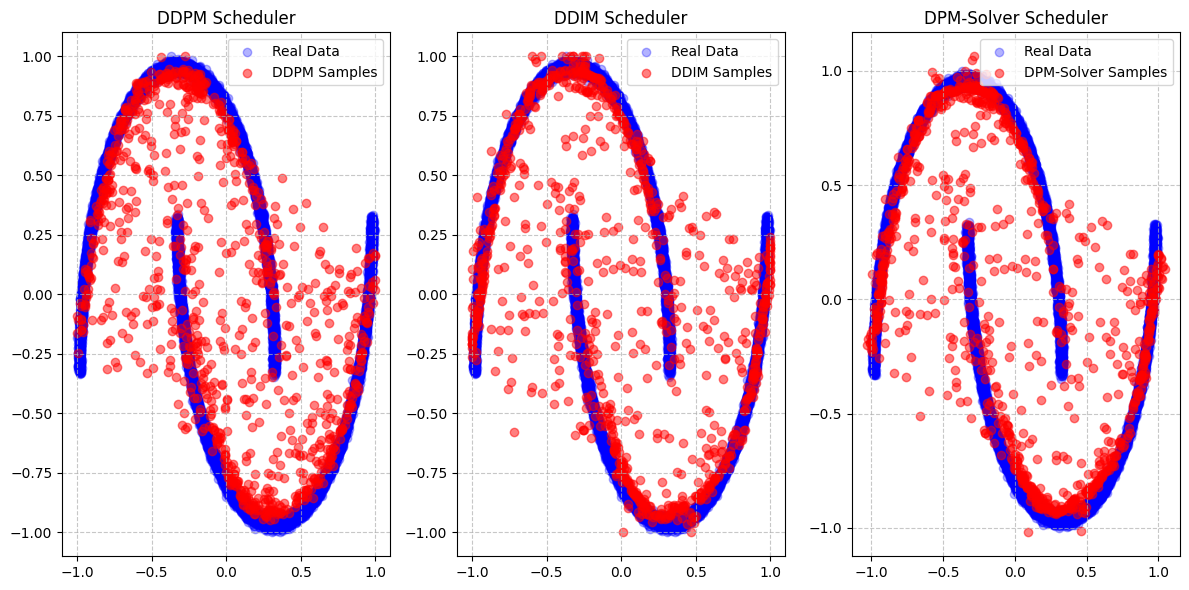

In [ ]:
def sample_with_scheduler(scheduler, model, n_samples=100, nfe=5, seed=42):
    torch.manual_seed(seed)
    x = torch.randn((n_samples, 2), device=device)  # Start from random noise
    scheduler.set_timesteps(num_inference_steps=nfe, device=device)

    for t in scheduler.timesteps:
        time_tensor = torch.full((n_samples,), t, device=device)
        predicted_noise = model(x, time_tensor)
        x = scheduler.step(predicted_noise, t, x).prev_sample

    return x
def visualize_solvers(schedulers, model, n_samples=1000, seed=42):

    plt.figure(figsize=(12, 6))

    for i, (name, scheduler) in enumerate(schedulers.items(), 1):
        with torch.no_grad():
            samples = sample_with_scheduler(scheduler, model, n_samples, seed=seed)
        X_real = X.cpu().numpy()
        samples_final = samples.cpu().numpy()
        plt.subplot(1, len(schedulers), i)
        plt.scatter(X_real[:, 0], X_real[:, 1], color="blue", alpha=0.3, label="Real Data")
        plt.scatter(samples_final[:, 0], samples_final[:, 1], color="red", alpha=0.5, label=f"{name} Samples")
        plt.title(f"{name} Scheduler")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

schedulers = {
    "DDPM": DDPMScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T),
    "DDIM": DDIMScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T),
    "DPM-Solver": DPMSolverMultistepScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T, prediction_type="epsilon")
}

visualize_solvers(schedulers, model, n_samples=1000, seed=42)

Starting evaluations...
Evaluating NFE=1...
Evaluating NFE=2...
Evaluating NFE=3...
Evaluating NFE=4...
Evaluating NFE=5...
Evaluating NFE=6...
Evaluating NFE=7...
Evaluating NFE=8...
Evaluating NFE=9...
Evaluating NFE=10...


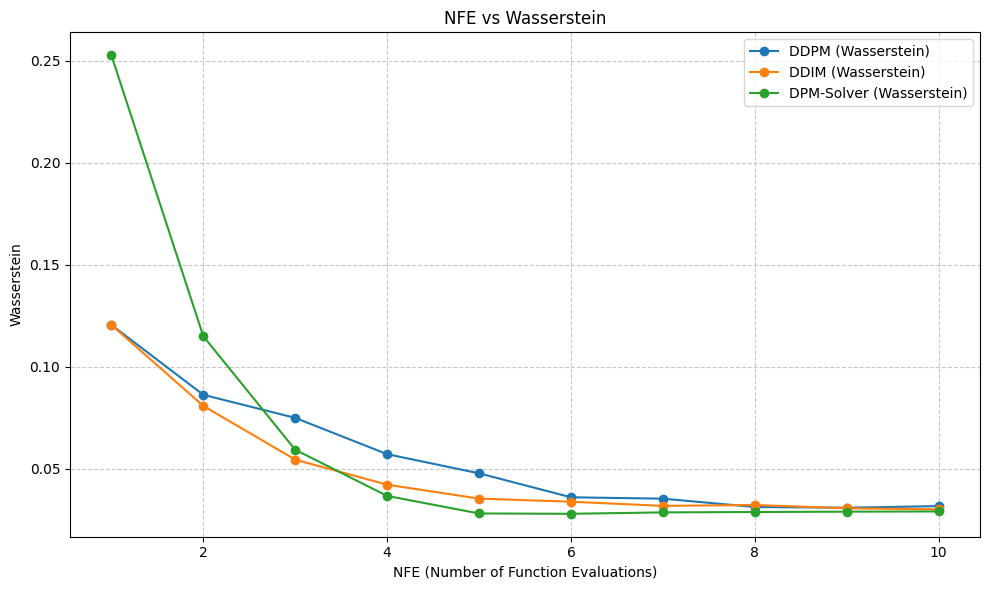

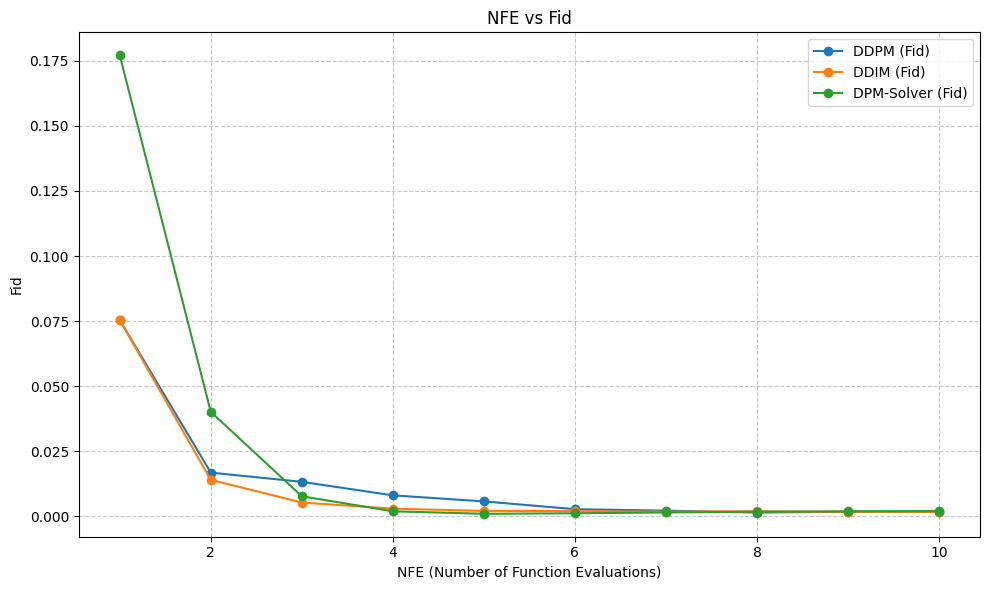

In [ ]:
def evaluate_metric(scheduler, model, n_samples=1000, nfe=50, seed=42, metric="wasserstein"):
    samples = sample_with_scheduler(scheduler, model, n_samples, nfe, seed)
    real_features = X.detach().cpu().numpy() if isinstance(X, torch.Tensor) else X
    generated_features = samples.detach().cpu().numpy() if isinstance(samples, torch.Tensor) else np.asarray(samples)

    if metric == "wasserstein":
        return np.mean([
            wasserstein_distance(real_features[:, dim], generated_features[:, dim])
            for dim in range(real_features.shape[1])
        ])
    elif metric == "fid":
        mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
        mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)
        return calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    else:
        raise ValueError("Unsupported metric. Use 'wasserstein' or 'fid'.")

# Simplified scheduler evaluation
def evaluate_schedulers(schedulers, model, nfe_values, metrics=("wasserstein", "fid"), n_samples=1000, seed=42):
    results = {metric: {name: [] for name in schedulers.keys()} for metric in metrics}
    results["NFE"] = nfe_values

    for nfe in nfe_values:
        print(f"Evaluating NFE={nfe}...")
        for name, scheduler in schedulers.items():
            for metric in metrics:
                results[metric][name].append(
                    evaluate_metric(scheduler, model, n_samples, nfe, seed, metric=metric)
                )

    return results

# Plotting results
def plot_results(results, metrics=("wasserstein", "fid")):
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for name, values in results[metric].items():
            if name == "NFE":
                continue
            plt.plot(results["NFE"], values, marker="o", label=f"{name} ({metric.capitalize()})")
        plt.title(f"NFE vs {metric.capitalize()}")
        plt.xlabel("NFE (Number of Function Evaluations)")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

# Define schedulers
schedulers = {
    "DDPM": DDPMScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T),
    "DDIM": DDIMScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T),
    "DPM-Solver": DPMSolverMultistepScheduler(beta_start=betas[0].item(), beta_end=betas[-1].item(), num_train_timesteps=T, prediction_type="epsilon")
}

# Evaluate schedulers
nfe_values = range(1, 11)  # Test NFE values from 1 to 10
metrics_to_evaluate = ("wasserstein", "fid")

print("Starting evaluations...")
evaluation_results = evaluate_schedulers(schedulers, model, nfe_values, metrics=metrics_to_evaluate)

# Plot results
plot_results(evaluation_results, metrics=metrics_to_evaluate)


## Conclusions

Since make_moons dataset seems to be a very simple dataset, we believe the comparassion beetween the three methods cannot properly be seen, once in few iterations the Wassertein and FID distances go to zero.